Abstract

[**hdf5plugin**](https://github.com/silx-kit/hdf5plugin) is a *Python* package (1) providing a set of [**HDF5**](https://portal.hdfgroup.org/display/HDF5/) compression filters (namely: Blosc, Blosc2, BitShuffle, BZip2, FciDecomp, LZ4, SZ, SZ3, ZFP, ZStandard) and (2) enabling their use from the *Python* programming language with [**h5py**](https://docs.h5py.org/) a thin, pythonic wrapper around `libHDF5`.

This presentation illustrates how to use **hdf5plugin** for reading and writing compressed datasets from *Python* and gives an overview of the different HDF5 compression filters it provides.

License: [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)

In [ ]:
# Notebook requirements
# A recent version of Pillow is required!
#%pip install numpy h5py hdf5plugin h5glance rise jupyterlab matplotlib ipympl Pillow

In [ ]:
%matplotlib inline

# Creates data.h5 used for demos
from matplotlib import pyplot as plt
import h5py
import hdf5plugin
import numpy
from PIL import Image
import urllib.request

url = "https://www.desy.de/e409/e116959/e119238/media/7795/1963_Luftbild_DESY-Gelaende_1284_gf_01sw_a3.jpg"
filename = urllib.request.urlretrieve(url)[0]
image = numpy.array(Image.open(filename).convert("L"))
plt.imshow(image, cmap="gray")

h5file = h5py.File("data.h5", mode="w")
h5file["copyright"] = "DESY"
h5file.attrs["url"] = url
h5file.create_dataset("/data", data=image)
h5file.create_dataset(
    "/compressed_data",
    data=image,
    chunks=image.shape,
    **hdf5plugin.Blosc2('lz4', filters=hdf5plugin.Blosc.BITSHUFFLE)
)
h5file.close()

**Restart kernel once the file is created!**

In [ ]:
import os
os._exit(0)  # Makes the kernel restart

![ESRF logo](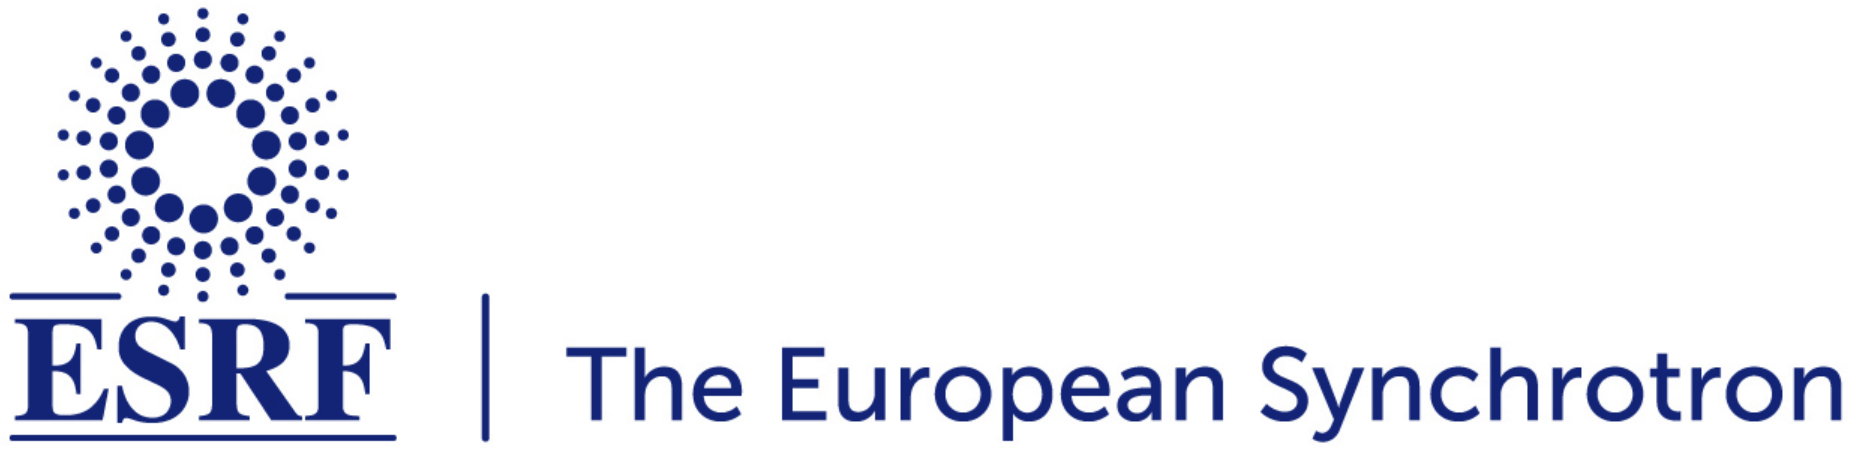 "ESRF logo")

&nbsp;

<table align="right" vertical-align="bottom" width="15%"><tr>
    <td></td>
    <td>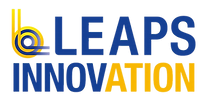</td>
</tr></table>

# hdf5plugin

[**hdf5plugin**](https://github.com/silx-kit/hdf5plugin) packages a set of [HDF5](https://portal.hdfgroup.org/display/HDF5/) compression filters and makes them usable from the Python programming language through [h5py](https://docs.h5py.org/).

[**h5py**](https://docs.h5py.org/) is a thin, pythonic wrapper around [HDF5](https://portal.hdfgroup.org/display/HDF5/).

&nbsp;

&nbsp;

Presenter: Thomas VINCENT

European HDF5 User Group Meeting 2023, September 19, 2023

In [1]:
from h5glance import H5Glance  # Browsing HDF5 files
H5Glance("data.h5")

data.h5/ (1 attributes)
├compressed_data	[uint8: 3744 × 5286]
├copyright	[UTF-8 string: scalar]
└data	[uint8: 3744 × 5286]

In [2]:
import h5py  # Pythonic HDF5 wrapper: https://docs.h5py.org/

h5file = h5py.File("data.h5", mode="r")  # Open HDF5 file in read mode
data = h5file["/data"][()]               # Access HDF5 dataset "/data"

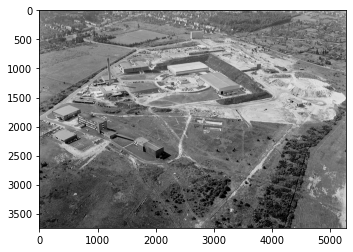

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.imshow(data, cmap="gray")

In [4]:
data = h5file["/compressed_data"][()]  # Access compressed dataset

OSError: Can't read data (can't open directory: /usr/local/hdf5/lib/plugin)

In [ ]:
# Check dataset's filters
plist = h5file["/compressed_data"].id.get_create_plist()
plist.get_filter(0)[0::3]

## `hdf5plugin` usage

### Reading compressed datasets

To enable reading compressed datasets not supported by `libHDF5` and `h5py`:
Install **hdf5plugin** & import it.

In [ ]:
%%bash
pip3 install hdf5plugin
# Or:
conda install -c conda-forge hdf5plugin

Or on [Debian12](https://packages.debian.org/bookworm/python3-hdf5plugin) and [Ubuntu23.04](https://packages.ubuntu.com/lunar/python3-hdf5plugin):

In [ ]:
%%bash
apt-get install python3-hdf5plugin

In [5]:
import hdf5plugin

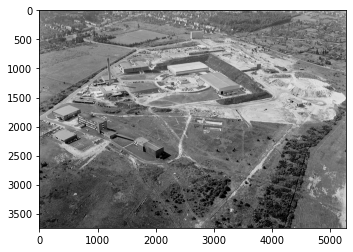

In [6]:
data = h5file["/compressed_data"][()]  # Access datset
plt.imshow(data, cmap="gray")          # Display data

In [7]:
h5file.close()  # Close the HDF5 file

### Writing compressed datasets

When writing datasets with `h5py`, compression can be specified with: [h5py.Group.create_dataset](https://docs.h5py.org/en/stable/high/group.html?highlight=create_dataset#h5py.Group.create_dataset)

In [8]:
# Create a dataset with h5py without compression
h5file = h5py.File("new_file_uncompressed.h5", mode="w")
h5file.create_dataset("/data", data=data)
h5file.close()

In [9]:
# Create a compressed dataset
h5file = h5py.File("new_file_blosc2_bitshuffle_lz4.h5", mode="w")
h5file.create_dataset(
    "/compressed_data",
    data=data,
    compression=32026,  # Blosc2 HDF5 filter identifier
    # options: 0, 0, 0, 0, level, filter, compression
    compression_opts=(0, 0, 0, 0, 5, 2, 1)  
)
h5file.close()

`hdf5plugin` provides some [helpers](http://www.silx.org/doc/hdf5plugin/latest/usage.html#write-compressed-datasets) to ease dealing with compression filter and options:

In [10]:
h5file = h5py.File("new_file_blosc2_bitshuffle_lz4.h5", mode="w")
h5file.create_dataset(
    "/compressed_data",
    data=data,
    compression=hdf5plugin.Blosc2(
        cname='lz4',
        clevel=5,
        filters=hdf5plugin.Blosc2.BITSHUFFLE),
)
h5file.close()

In [ ]:
help(hdf5plugin.Blosc2)

In [12]:
H5Glance("new_file_blosc2_bitshuffle_lz4.h5")

new_file_blosc2_bitshuffle_lz4.h5/
└compressed_data	[uint8: 3744 × 5286]

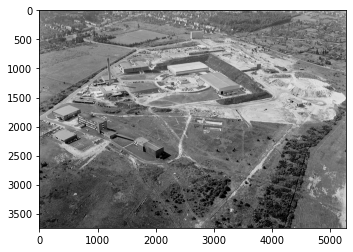

In [13]:
h5file = h5py.File("new_file_blosc2_bitshuffle_lz4.h5", mode="r")
plt.imshow(h5file["/compressed_data"][()], cmap="gray")
h5file.close()

In [14]:
!ls -sh new_file*.h5

18M new_file_blosc2_bitshuffle_lz4.h5  19M new_file_uncompressed.h5


## HDF5 compression filters

### Available through `h5py`

- Pre-compression filter: [Byte-Shuffle](https://docs.h5py.org/en/stable/high/dataset.html#shuffle-filter) provided by `libhdf5`
- [Compression filters provided by h5py](https://docs.h5py.org/en/stable/high/dataset.html#lossless-compression-filters):

  - Provided by `libhdf5`: **"gzip"** and eventually **"szip"** (optional)
  - Bundled with `h5py`: [**"lzf"**](https://confluence.hdfgroup.org/display/support/Filters#Filters-32000)

In [15]:
h5file = h5py.File("new_file_shuffle_gzip.h5", mode="w")
h5file.create_dataset(
    "/compressed_data_shuffle_gzip", data=data, shuffle=True, compression="gzip")
h5file.close()

### Provided by `hdf5plugin`

Additional compression filters provided by `hdf5plugin`:

BitShuffle, Blosc, Blosc2, BZip2, FciDecomp, LZ4, SZ, SZ3, ZFP, Zstandard

10 out of the 29 [HDF5 registered filter plugins](https://confluence.hdfgroup.org/display/support/Registered+Filter+Plugins) as of September 2023

In [16]:
h5file = h5py.File("new_file_bitshuffle_lz4.h5", mode="w")
h5file.create_dataset(
    "/compressed_data_bitshuffle_lz4",
    data=data,
    compression=hdf5plugin.Bitshuffle()
)
h5file.close()

#### General purpose lossless compression

- [Bitshuffle(nelems=0, cname='lz4', clevel=3)](http://www.silx.org/doc/hdf5plugin/latest/usage.html#bitshuffle) - ID [32008](https://confluence.hdfgroup.org/display/support/Filters#Filters-32008)
  - **Bit**-Shuffle + LZ4, ZStd or no compression
- [BZip2(blocksize=9)](http://www.silx.org/doc/hdf5plugin/latest/usage.html#bzip2) - ID [307](https://confluence.hdfgroup.org/display/support/Filters#Filters-307)
- [LZ4(nbytes=0)](http://www.silx.org/doc/hdf5plugin/latest/usage.html#lz4) - ID [32004](https://confluence.hdfgroup.org/display/support/Filters#Filters-32004)
- [Zstd(clevel=3)](http://www.silx.org/doc/hdf5plugin/latest/usage.html#zstd) - ID [32015](https://confluence.hdfgroup.org/display/support/Filters#Filters-32015)

#### Specific compression

- [FciDecomp()](http://www.silx.org/doc/hdf5plugin/latest/usage.html#fcidecomp) - ID [32018](https://confluence.hdfgroup.org/display/support/Filters#Filters-32018): Based on JPEG-LS:
  - **Optional**: requires C++11
  - Data type: `(u)int8` or `(u)int16`
  - Chunk shape: "Image-like"; 2 or 3 dimensions with at least 16 pixels and at most 65535 rows and columns and at most 4 planes for 3D datasets.


#### Lossy compression 1/2

[SZcompressor](https://szcompressor.org/) family: error-bounded lossy compression

- [SZ(absolute=None, relative=None, pointwise_relative=None)](http://www.silx.org/doc/hdf5plugin/latest/usage.html#sz) - ID [32017](https://confluence.hdfgroup.org/display/support/Filters#Filters-32017)
- [SZ3(absolute=None, relative=None, norm2=None, peak_signal_to_noise_ratio=None)](http://www.silx.org/doc/hdf5plugin/latest/usage.html#sz3) - ID [32024](https://confluence.hdfgroup.org/display/support/Filters#Filters-32024)

#### Lossy compression 2/2

- [ZFP(rate=None, precision=None, accuracy=None, reversible=False, minbits=None, maxbits=None, maxprec=None, minexp=None)](http://www.silx.org/doc/hdf5plugin/latest/usage.html#zfp) - ID [32013](https://confluence.hdfgroup.org/display/support/Filters#Filters-32013):
  - Data type: `float32`, `float64`, `(u)int32`, `(u)int64`
  - Chunk shape: must have at most 4 non-unity dimensions

#### Meta-compressor: Blosc family

- [Blosc(cname='lz4', clevel=5, shuffle=1)](http://www.silx.org/doc/hdf5plugin/latest/usage.html#blosc) - ID [32001](https://confluence.hdfgroup.org/display/support/Filters#Filters-32001):
  - Based on [c-blosc](https://github.com/blosc/c-blosc): A blocking, shuffling and lossless compression library
  - Pre-compression shuffle: None, **Byte**-Shuffle, **Bit**-Shuffle
  - Compression: `blosclz`, `lz4`, `lz4hc`, `snappy` (**optional**, requires C++11), `zlib`, `zstd`
- [Blosc2(cname='blosclz', clevel=5, filters=1)](http://www.silx.org/doc/hdf5plugin/latest/usage.html#blosc2) - ID [32026](https://confluence.hdfgroup.org/display/support/Filters#Filters-32026):
  - Based on [c-blosc2](https://github.com/blosc/c-blosc2): A high performance compressor optimized for binary data
  - Pre-compression filters: None, **Byte**-Shuffle, **Bit**-Shuffle, and more
  - Compression: `blosclz`, `lz4`, `lz4hc`, `zlib`, `zstd`
  - More filters and compressions can be supported: `zfp`, `htj2k`

#### Equivalent filters

`Blosc` and `Blosc2` includes some pre-compression filters and algorithms provided by other HDF5 compression filters:

- HDF5 shuffle  => `Blosc2(..., filters=Blosc2.SHUFFLE)`
- `Bitshuffle()` => `Blosc2("lz4" or "zstd", 5, Blosc2.BITSHUFFLE)`
- `LZ4()` => `Blosc2("lz4", 9)`
- `Zstd()` => `Blosc2("zstd", 2)`

`Blosc2` filter could also provide `ZFP`

### A look at performances on a single use case

- Machine: Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz (40 cores)
- Filesystem: /dev/shm
- `hdf5plugin` built from source


- Running on a single core


- Diffraction tomography dataset: 100 frames from http://www.silx.org/pub/pyFAI/pyFAI_UM_2020/data_ID13/kevlar.h5
- Dataset: 100x2167x2070, uint16, chunk: 2167x2070

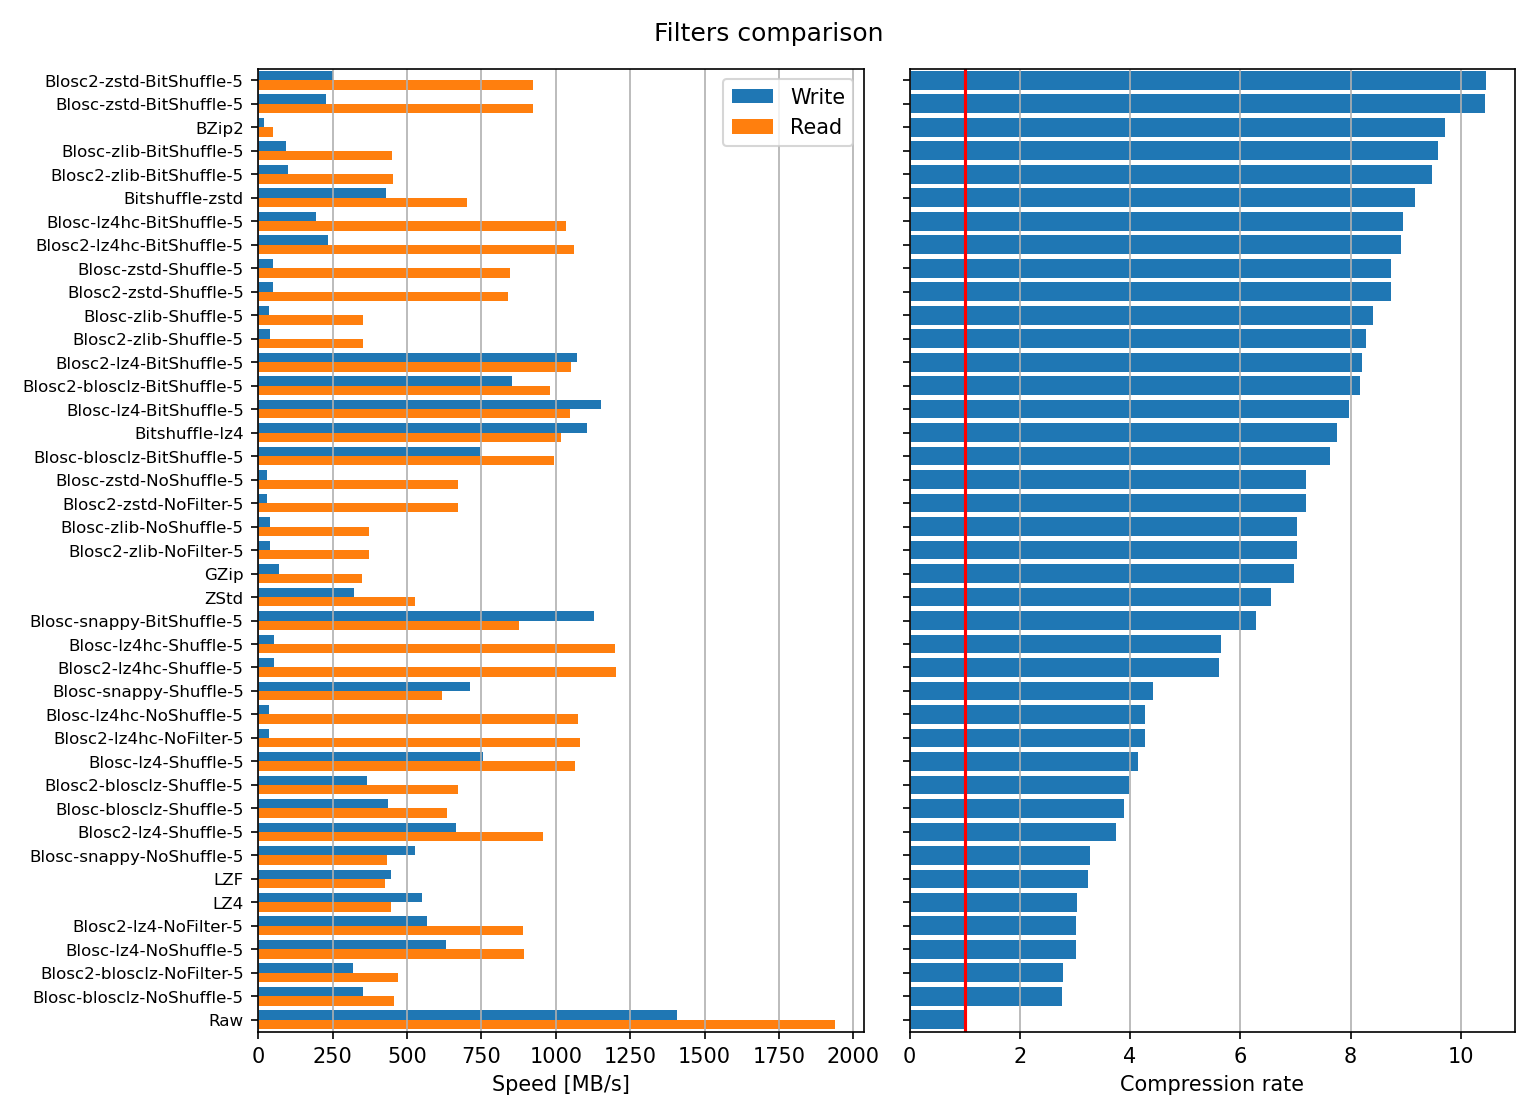

#### Multithreaded filter execution

Some filters can use multithreading:

- Blosc/Blosc2:
  - Using a pool of threads
  - Disabled by default for Blosc1
  - Configurable with `BLOSC_NTHREADS` environment variable
- Bitshuffle, Fcidecomp, SZ, SZ3, ZFP:
  - Using OpenMP
  - Enabled at compilation time
  - If enabled, configurable with `OMP_NUM_THREADS` environment variable

Performance do not increase linearly with the number of CPU cores used.

### Summary

Having different pre-compression filters and compression algorithms at hand offers different read/write speed versus compression rate (and eventually error rate) trade-offs.

Also to keep in mind availability/compatibility: Since `"gzip"` is included in `libHDF5` it is the most compatible one (and also `"lzf"` as included in `h5py`).

## Using `hdf5plugin` filters with other applications

Set the `HDF5_PLUGIN_PATH` environment variable to: `hdf5plugin.PLUGINS_PATH`

In [ ]:
%%bash
export HDF5_PLUGIN_PATH=`python3 -c "
import hdf5plugin; print(hdf5plugin.PLUGINS_PATH)"`
echo "HDF5_PLUGIN_PATH=${HDF5_PLUGIN_PATH}"
ls ${HDF5_PLUGIN_PATH}

**Note**: Only works for reading compressed datasets, **not for writing!**

## A word about `hdf5plugin` license

The source code of `hdf5plugin` itself is licensed under the [MIT](https://github.com/silx-kit/hdf5plugin/blob/main/LICENSE) license...

It also embeds the source code of the provided compression filters and libraries which are licensed under [different open-source licenses](http://www.silx.org/doc/hdf5plugin/latest/information.html#license) (Apache, BSD-2, BSD-3, MIT, Zlib...) and copyrights.

## Limitations

- Only "gzip" available by default:
  - Many compression filters provided by `hdf5plugin` are included in [c-blosc2](https://github.com/blosc/c-blosc2)
- A central repository for filters source code: https://github.com/HDFGroup/hdf5_plugins?

- Need to link filters with libhdf5:
  - `hdf5plugin` relies on a "hack" to avoid linking with libhdf5

- Compressed data accessed by "chunks" even if compressor uses smaller blocks
- Multi-threaded access support
- When reading compressed data, some memory copy could be spared:
  - Direct chunk access offers a way to improve performance/flexibility

### Avoid memory copies

Compression filters allocates a memory buffer to store decompressed data = memory copies.

Allowing the user to pass a memory buffer through h5py->libhdf5->compression_filter would prevent it.

An example with **h5py** and **Blosc2** (bitshuffle+lz4) for a 8.5MB chunk on 1 core (± ~300 µs):

- Standard access `dataset[()]`: 8.9 ms
- `read_direct()` to existing array: 5.2 ms
- `read_direct_chunk()` & decompression with `blosc2`: 3.7 ms

# Credits

**To hdf5plugin** [**contributors**](https://github.com/silx-kit/hdf5plugin/graphs/contributors): [Armando Sole](https://github.com/vasole), [\@orioltinto](https://github.com/orioltinto), [\@mkitti ](https://github.com/mkitti), [\@Florian-toll](https://github.com/Florian-toll), [Jerome Kieffer](https://github.com/kif), [\@fpwg](https://github.com/fpwg), [\@mobiusklein ](https://github.com/mobiusklein), [\@junyuewang](https://github.com/junyuewang), [\@Anthchirp](https://github.com/Anthchirp), and

**to all contributors of embedded libraries**

&nbsp;

&nbsp;

Partially funded by the [LEAPS-INNOV](https://www.leaps-innov.eu/) and [PaNOSC](https://www.panosc.eu/) EU-project.


<img align="left" vertical-align="top" width="5%" src="data:image/svg+xml,%3Csvg%20width%3D%2240.5%22%20height%3D%2227%22%20version%3D%221.1%22%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20xmlns%3Axlink%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2Fxlink%22%3E%3Cdesc%3EEuropean%20flag%3C%2Fdesc%3E%3Cdefs%3E%3Cg%20id%3D%22s%22%3E%3Cg%20id%3D%22c%22%3E%3Cpath%20id%3D%22t%22%20transform%3D%22rotate%2818%203.1569%20-.5%29%22%20d%3D%22m0%200v1h0.5z%22%2F%3E%3Cuse%20transform%3D%22scale%28-1%2C1%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23t%22%2F%3E%3C%2Fg%3E%3Cg%20id%3D%22a%22%3E%3Cuse%20transform%3D%22rotate%2872%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23c%22%2F%3E%3Cuse%20transform%3D%22rotate%28144%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23c%22%2F%3E%3C%2Fg%3E%3Cuse%20transform%3D%22scale%28-1%2C1%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23a%22%2F%3E%3C%2Fg%3E%3C%2Fdefs%3E%3Crect%20width%3D%2240.5%22%20height%3D%2227%22%20fill%3D%22%23039%22%20stroke-width%3D%22.05%22%2F%3E%3Cg%20transform%3D%22matrix%281.5%2C0%2C0%2C1.5%2C20.25%2C13.5%29%22%20fill%3D%22%23fc0%22%3E%3Cuse%20y%3D%22-6%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3Cuse%20y%3D%226%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3Cg%20id%3D%22l%22%3E%3Cuse%20x%3D%22-6%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3Cuse%20transform%3D%22rotate%28216%20-2.3442%20-2.1107%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3Cuse%20transform%3D%22rotate%28144%2C-2.1107%2C-2.3442%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3Cuse%20transform%3D%22rotate%2872%2C-4.6626%2C-2.0759%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3Cuse%20transform%3D%22rotate%2872%20-5.0759%20.5335%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3C%2Fg%3E%3Cuse%20transform%3D%22scale%28-1%2C1%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23l%22%2F%3E%3C%2Fg%3E%3C%2Fsvg%3E"/>&nbsp;<small>This project has received funding from the European Union´s Horizon 2020 research and innovation programme under grant agreement no. 101004728 and 823852.</small>


# Conlusion

`hdf5plugin` provides additional HDF5 compression filters (namely: BitShuffle, Blosc, Blosc2, BZip2, FciDecomp, LZ4, SZ, SZ3, ZFP, Zstandard) mainly for use with [h5py](https://docs.h5py.org/).

- Packaged for [**pip**](https://pypi.org/project/hdf5plugin/) and [**conda**](https://anaconda.org/conda-forge/hdf5plugin)
- Documentation: http://www.silx.org/doc/hdf5plugin/latest/
- Source code repository: https://github.com/silx-kit/hdf5plugin

# Thanks for your attention! Questions?